In [1]:
import sys
sys.setrecursionlimit(20000)
print(sys.getrecursionlimit())

20000


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

1

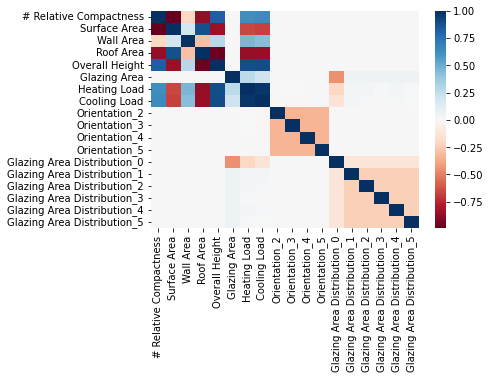

In [14]:
df = pd.read_csv("energy_efficiency_data.csv")

df = pd.get_dummies(data=df, columns=['Orientation','Glazing Area Distribution'])
sns.heatmap(df.corr(),cmap='RdBu')
y = df['Heating Load']
df.drop(['Heating Load'], axis=1, inplace=True)
df.drop(['Cooling Load'], axis=1, inplace=True)
y_train = y.iloc[:576]
y_train = y_train.to_numpy()
y_train = y_train.reshape((576,1))
y_test = y.iloc[576:]
y_test = y_test.to_numpy()
y_test = y_test.reshape((192,1))
X_train = df.iloc[:576,:]
X_test = df.iloc[576:,:]
X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

In [3]:
network1 = [{"input_dim":16,"output_dim":32,"activation":"sigmoid"},
           {"input_dim":32,"output_dim":64,"activation":"sigmoid"},
           {"input_dim":64,"output_dim":128,"activation":"sigmoid"},
           {"input_dim":128,"output_dim":64,"activation":"sigmoid"},
           {"input_dim":64,"output_dim":32,"activation":"sigmoid"},
           {"input_dim":32,"output_dim":16,"activation":"sigmoid"},
           {"input_dim":16,"output_dim":1,"activation":"sigmoid"}]
network2 = [{"input_dim":4,"output_dim":32,"activation":"sigmoid"},
           {"input_dim":32,"output_dim":64,"activation":"sigmoid"},
           {"input_dim":64,"output_dim":128,"activation":"sigmoid"},
           {"input_dim":128,"output_dim":64,"activation":"sigmoid"},
           {"input_dim":64,"output_dim":32,"activation":"sigmoid"},
           {"input_dim":32,"output_dim":16,"activation":"sigmoid"},
           {"input_dim":16,"output_dim":1,"activation":"sigmoid"}]
network3 = [{"input_dim":34,"output_dim":68,"activation":"relu"},
           {"input_dim":68,"output_dim":136,"activation":"relu"},
           {"input_dim":136,"output_dim":272,"activation":"relu"},
           {"input_dim":272,"output_dim":136,"activation":"relu"},
           {"input_dim":136,"output_dim":68,"activation":"relu"},
           {"input_dim":68,"output_dim":34,"activation":"relu"},
           {"input_dim":34,"output_dim":1,"activation":"relu"}]

In [4]:
def initial(network):
    np.random.seed(123)
    allW_values = {}
    allb_values = {}
    for idx,layer in enumerate(network):
        allW_values['W' + str(idx+1)] = np.random.randn(layer["output_dim"], layer["input_dim"])*0.1
        allb_values['b' + str(idx+1)] = np.random.randn(layer["output_dim"], 1) *0.1
    return allW_values,allb_values

In [5]:
def forward(X,network,allW_values,allb_values):
  go={'X0':X}
  for idx,layer in enumerate(network):
    A = np.dot(allW_values['W' + str(idx+1)],X) + allb_values['b' + str(idx+1)]
    if layer["activation"] == "sigmoid":
      X = 1/(1+np.exp(-A))
    elif layer["activation"] == "relu":
      X = np.maximum(0,A)
    go['A' + str(idx+1)] = A
    go['X' + str(idx+1)] = X
  return go

In [6]:
def loss1(y,y_pre):
  sumofsquare = y-y_pre
  np.square(sumofsquare,sumofsquare)
  sumofsquare = np.squeeze(sumofsquare)
  return sumofsquare.sum()
  
def loss2(y,y_pre):
  crossentropy = -1 * (np.dot(y, np.log((y_pre).astype(float)).T) + np.dot(1 - y, np.log((1 - y_pre).astype(float)).T))
  crossentropy = np.squeeze(crossentropy)
  return crossentropy.sum()

In [7]:
def backward(y,y_pre,network,allW_values,allb_values,go):
  dW={}
  db={}
  m=576
  if network == network3:
    dXpre = - (np.divide(y, y_pre) - np.divide(1 - y, 1 - y_pre))
  else:
    dXpre = -2*(y-y_pre)
  for idx,layer in reversed(list(enumerate(network))):
    dX = dXpre
    Xpre = go['X'+str(idx)]
    A = go['A'+str(idx+1)]
    W = allW_values['W'+str(idx+1)]
    b = allb_values['b'+str(idx+1)]
    if layer["activation"] == "sigmoid":
      sig = 1/(1+np.exp(-A))
      dA = dX * sig * (1 - sig)
    elif layer["activation"] == "relu":
      dA = np.array(dX, copy = True)
      dA[A <= 0] = 0
     
    dW['dW'+str(idx+1)] = np.dot(dA, Xpre.T) / m

    db['db'+str(idx+1)] = np.sum(dA, axis=1, keepdims=True) / m

    dXpre = np.dot(W.T,dA)
  return dW,db

In [8]:
def update(network,allW_values,allb_values,dW,db,lr):
  for idx,layer in enumerate(network):
    allW_values['W'+str(idx+1)] = allW_values['W'+str(idx+1)] - lr*dW['dW'+str(idx+1)]
    allb_values['b'+str(idx+1)] = allb_values['b'+str(idx+1)] - lr*db['db'+str(idx+1)]
  return allW_values,allb_values

In [21]:
costtr_history = []
costte_history = []
lr = 0.001
epoch = 1000
allW_values,allb_values = initial(network1)
for i in range(epoch):
  gotrain = forward(X_train,network1,allW_values,allb_values)
  gotest = forward(X_test,network1,allW_values,allb_values)
  losstrain = loss1(y_train,gotrain["X7"])
  
  
  losstest = loss1(y_test,gotest["X7"])
  print('(epoch = {:4d}, loss = {:.4f})'.format(i + 1, losstrain))
  costtr_history.append(losstrain)
  costte_history.append(losstest)

  dW,db = backward(y_train,gotrain["X7"],network1,allW_values,allb_values,gotrain)
  allW_values,allb_values = update(network1,allW_values,allb_values,dW,db,lr)

(epoch =    1, loss = 332942.3188)
(epoch =    2, loss = 332543.0258)
(epoch =    3, loss = 332144.6508)
(epoch =    4, loss = 331748.7084)
(epoch =    5, loss = 331356.6676)
(epoch =    6, loss = 330969.9226)
(epoch =    7, loss = 330589.7673)
(epoch =    8, loss = 330217.3746)
(epoch =    9, loss = 329853.7802)
(epoch =   10, loss = 329499.8723)
(epoch =   11, loss = 329156.3867)
(epoch =   12, loss = 328823.9071)
(epoch =   13, loss = 328502.8693)
(epoch =   14, loss = 328193.5694)
(epoch =   15, loss = 327896.1750)
(epoch =   16, loss = 327610.7373)
(epoch =   17, loss = 327337.2056)
(epoch =   18, loss = 327075.4410)
(epoch =   19, loss = 326825.2308)
(epoch =   20, loss = 326586.3014)
(epoch =   21, loss = 326358.3312)
(epoch =   22, loss = 326140.9617)
(epoch =   23, loss = 325933.8073)
(epoch =   24, loss = 325736.4644)
(epoch =   25, loss = 325548.5187)
(epoch =   26, loss = 325369.5515)
(epoch =   27, loss = 325199.1450)
(epoch =   28, loss = 325036.8861)
(epoch =   29, loss 

(epoch =  250, loss = 320675.0217)
(epoch =  251, loss = 320673.3129)
(epoch =  252, loss = 320671.6194)
(epoch =  253, loss = 320669.9408)
(epoch =  254, loss = 320668.2771)
(epoch =  255, loss = 320666.6280)
(epoch =  256, loss = 320664.9934)
(epoch =  257, loss = 320663.3731)
(epoch =  258, loss = 320661.7668)
(epoch =  259, loss = 320660.1745)
(epoch =  260, loss = 320658.5959)
(epoch =  261, loss = 320657.0308)
(epoch =  262, loss = 320655.4792)
(epoch =  263, loss = 320653.9408)
(epoch =  264, loss = 320652.4155)
(epoch =  265, loss = 320650.9031)
(epoch =  266, loss = 320649.4034)
(epoch =  267, loss = 320647.9163)
(epoch =  268, loss = 320646.4416)
(epoch =  269, loss = 320644.9793)
(epoch =  270, loss = 320643.5291)
(epoch =  271, loss = 320642.0909)
(epoch =  272, loss = 320640.6645)
(epoch =  273, loss = 320639.2498)
(epoch =  274, loss = 320637.8467)
(epoch =  275, loss = 320636.4551)
(epoch =  276, loss = 320635.0747)
(epoch =  277, loss = 320633.7055)
(epoch =  278, loss 

(epoch =  510, loss = 320471.5915)
(epoch =  511, loss = 320471.2415)
(epoch =  512, loss = 320470.8930)
(epoch =  513, loss = 320470.5460)
(epoch =  514, loss = 320470.2005)
(epoch =  515, loss = 320469.8565)
(epoch =  516, loss = 320469.5140)
(epoch =  517, loss = 320469.1729)
(epoch =  518, loss = 320468.8333)
(epoch =  519, loss = 320468.4951)
(epoch =  520, loss = 320468.1584)
(epoch =  521, loss = 320467.8231)
(epoch =  522, loss = 320467.4892)
(epoch =  523, loss = 320467.1567)
(epoch =  524, loss = 320466.8256)
(epoch =  525, loss = 320466.4959)
(epoch =  526, loss = 320466.1676)
(epoch =  527, loss = 320465.8406)
(epoch =  528, loss = 320465.5151)
(epoch =  529, loss = 320465.1908)
(epoch =  530, loss = 320464.8680)
(epoch =  531, loss = 320464.5464)
(epoch =  532, loss = 320464.2262)
(epoch =  533, loss = 320463.9074)
(epoch =  534, loss = 320463.5898)
(epoch =  535, loss = 320463.2736)
(epoch =  536, loss = 320462.9586)
(epoch =  537, loss = 320462.6450)
(epoch =  538, loss 

(epoch =  771, loss = 320413.3216)
(epoch =  772, loss = 320413.1804)
(epoch =  773, loss = 320413.0395)
(epoch =  774, loss = 320412.8991)
(epoch =  775, loss = 320412.7591)
(epoch =  776, loss = 320412.6194)
(epoch =  777, loss = 320412.4802)
(epoch =  778, loss = 320412.3413)
(epoch =  779, loss = 320412.2028)
(epoch =  780, loss = 320412.0648)
(epoch =  781, loss = 320411.9271)
(epoch =  782, loss = 320411.7898)
(epoch =  783, loss = 320411.6528)
(epoch =  784, loss = 320411.5163)
(epoch =  785, loss = 320411.3801)
(epoch =  786, loss = 320411.2443)
(epoch =  787, loss = 320411.1089)
(epoch =  788, loss = 320410.9739)
(epoch =  789, loss = 320410.8392)
(epoch =  790, loss = 320410.7050)
(epoch =  791, loss = 320410.5710)
(epoch =  792, loss = 320410.4375)
(epoch =  793, loss = 320410.3043)
(epoch =  794, loss = 320410.1715)
(epoch =  795, loss = 320410.0391)
(epoch =  796, loss = 320409.9070)
(epoch =  797, loss = 320409.7753)
(epoch =  798, loss = 320409.6439)
(epoch =  799, loss 

training_RMS_error = 23.5845
testing_RMS_error = 23.5478


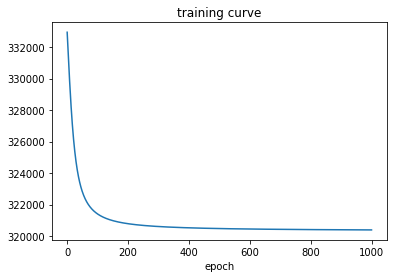

In [22]:
plt.plot(costtr_history)
plt.title ("training curve")
plt.xlabel("epoch")
training_RMS_error = np.sqrt(costtr_history[999]/576)
testing_RMS_error = np.sqrt(costte_history[999]/192)
print('training_RMS_error = {:.4f}'.format(training_RMS_error))
print('testing_RMS_error = {:.4f}'.format(testing_RMS_error))

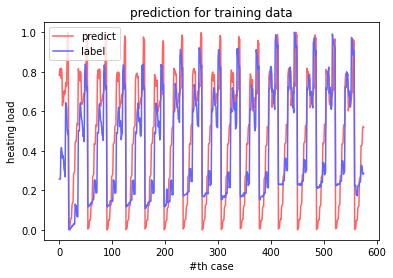

In [23]:
range1 = np.max(np.squeeze(y_train)) - np.min(np.squeeze(y_train))
aa=(np.squeeze(y_train) - np.min(np.squeeze(y_train))) / range1
range2 = np.max(np.squeeze(gotrain["X7"])) - np.min(np.squeeze(gotrain["X7"]))
ab=(np.squeeze(gotrain["X7"]) - np.min(np.squeeze(gotrain["X7"]))) / range2
plt.plot (ab,color=(255/255,100/255,100/255),label="predict")
plt.plot (aa,color=(100/255,100/255,255/255),label="label")
plt.title ("prediction for training data")
# title
plt.ylabel ("heating load")
# y label
plt.xlabel("#th case") #x label
plt.legend()
plt. show( )

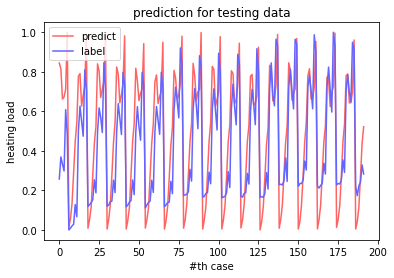

In [24]:
range1 = np.max(np.squeeze(y_test)) - np.min(np.squeeze(y_test))
aa=(np.squeeze(y_test) - np.min(np.squeeze(y_test))) / range1
range2 = np.max(np.squeeze(gotest["X7"])) - np.min(np.squeeze(gotest["X7"]))
ab=(np.squeeze(gotest["X7"]) - np.min(np.squeeze(gotest["X7"]))) / range2
plt.plot (ab,color=(255/255,100/255,100/255),label="predict")
plt.plot (aa,color=(100/255,100/255,255/255),label="label")
plt.title ("prediction for testing data")
# title
plt.ylabel ("heating load")
# y label
plt.xlabel("#th case") #x label
plt.legend()
plt. show( )

In [25]:
df.drop(['Surface Area','Roof Area','Glazing Area Distribution_0','Glazing Area Distribution_1',
         'Glazing Area Distribution_2','Glazing Area Distribution_3','Glazing Area Distribution_4',
         'Glazing Area Distribution_5','Orientation_2','Orientation_3','Orientation_4',
         'Orientation_5'], axis=1, inplace=True)
X_train = df.iloc[:576,:]
X_test = df.iloc[576:,:]
X_train = X_train.T
X_test = X_test.T

Training

In [39]:
costtr_history = []
costte_history = []
lr = 0.001
epoch = 1000
allW_values,allb_values = initial(network2)
for i in range(epoch):
  gotrain = forward(X_train,network2,allW_values,allb_values)
  gotest = forward(X_test,network2,allW_values,allb_values)
  losstrain = loss1(y_train,gotrain["X7"])
  
  print('(epoch = {:4d}, loss = {:.4f})'.format(i + 1, losstrain))
  losstest = loss1(y_test,gotest["X7"])
  
  costtr_history.append(losstrain)
  costte_history.append(losstest)

  dW,db = backward(y_train,gotrain["X7"],network2,allW_values,allb_values,gotrain)
  allW_values,allb_values = update(network2,allW_values,allb_values,dW,db,lr)

(epoch =    1, loss = 332857.4287)
(epoch =    2, loss = 332497.7101)
(epoch =    3, loss = 332139.0420)
(epoch =    4, loss = 331782.5116)
(epoch =    5, loss = 331429.1733)
(epoch =    6, loss = 331080.0318)
(epoch =    7, loss = 330736.0274)
(epoch =    8, loss = 330398.0244)
(epoch =    9, loss = 330066.8008)
(epoch =   10, loss = 329743.0416)
(epoch =   11, loss = 329427.3349)
(epoch =   12, loss = 329120.1707)
(epoch =   13, loss = 328821.9415)
(epoch =   14, loss = 328532.9461)
(epoch =   15, loss = 328253.3941)
(epoch =   16, loss = 327983.4124)
(epoch =   17, loss = 327723.0526)
(epoch =   18, loss = 327472.2987)
(epoch =   19, loss = 327231.0751)
(epoch =   20, loss = 326999.2549)
(epoch =   21, loss = 326776.6676)
(epoch =   22, loss = 326563.1065)
(epoch =   23, loss = 326358.3360)
(epoch =   24, loss = 326162.0974)
(epoch =   25, loss = 325974.1149)
(epoch =   26, loss = 325794.1006)
(epoch =   27, loss = 325621.7586)
(epoch =   28, loss = 325456.7893)
(epoch =   29, loss 

(epoch =  236, loss = 320738.5151)
(epoch =  237, loss = 320736.3358)
(epoch =  238, loss = 320734.1773)
(epoch =  239, loss = 320732.0393)
(epoch =  240, loss = 320729.9215)
(epoch =  241, loss = 320727.8236)
(epoch =  242, loss = 320725.7454)
(epoch =  243, loss = 320723.6866)
(epoch =  244, loss = 320721.6469)
(epoch =  245, loss = 320719.6262)
(epoch =  246, loss = 320717.6240)
(epoch =  247, loss = 320715.6403)
(epoch =  248, loss = 320713.6746)
(epoch =  249, loss = 320711.7269)
(epoch =  250, loss = 320709.7969)
(epoch =  251, loss = 320707.8843)
(epoch =  252, loss = 320705.9889)
(epoch =  253, loss = 320704.1105)
(epoch =  254, loss = 320702.2489)
(epoch =  255, loss = 320700.4038)
(epoch =  256, loss = 320698.5750)
(epoch =  257, loss = 320696.7624)
(epoch =  258, loss = 320694.9657)
(epoch =  259, loss = 320693.1847)
(epoch =  260, loss = 320691.4193)
(epoch =  261, loss = 320689.6692)
(epoch =  262, loss = 320687.9342)
(epoch =  263, loss = 320686.2142)
(epoch =  264, loss 

(epoch =  491, loss = 320491.4124)
(epoch =  492, loss = 320490.9935)
(epoch =  493, loss = 320490.5764)
(epoch =  494, loss = 320490.1612)
(epoch =  495, loss = 320489.7479)
(epoch =  496, loss = 320489.3364)
(epoch =  497, loss = 320488.9268)
(epoch =  498, loss = 320488.5191)
(epoch =  499, loss = 320488.1131)
(epoch =  500, loss = 320487.7090)
(epoch =  501, loss = 320487.3067)
(epoch =  502, loss = 320486.9062)
(epoch =  503, loss = 320486.5074)
(epoch =  504, loss = 320486.1104)
(epoch =  505, loss = 320485.7152)
(epoch =  506, loss = 320485.3217)
(epoch =  507, loss = 320484.9300)
(epoch =  508, loss = 320484.5399)
(epoch =  509, loss = 320484.1516)
(epoch =  510, loss = 320483.7650)
(epoch =  511, loss = 320483.3801)
(epoch =  512, loss = 320482.9968)
(epoch =  513, loss = 320482.6152)
(epoch =  514, loss = 320482.2353)
(epoch =  515, loss = 320481.8570)
(epoch =  516, loss = 320481.4804)
(epoch =  517, loss = 320481.1054)
(epoch =  518, loss = 320480.7319)
(epoch =  519, loss 

(epoch =  731, loss = 320426.5069)
(epoch =  732, loss = 320426.3339)
(epoch =  733, loss = 320426.1614)
(epoch =  734, loss = 320425.9894)
(epoch =  735, loss = 320425.8180)
(epoch =  736, loss = 320425.6470)
(epoch =  737, loss = 320425.4766)
(epoch =  738, loss = 320425.3067)
(epoch =  739, loss = 320425.1373)
(epoch =  740, loss = 320424.9684)
(epoch =  741, loss = 320424.8000)
(epoch =  742, loss = 320424.6321)
(epoch =  743, loss = 320424.4647)
(epoch =  744, loss = 320424.2978)
(epoch =  745, loss = 320424.1314)
(epoch =  746, loss = 320423.9655)
(epoch =  747, loss = 320423.8001)
(epoch =  748, loss = 320423.6352)
(epoch =  749, loss = 320423.4708)
(epoch =  750, loss = 320423.3068)
(epoch =  751, loss = 320423.1434)
(epoch =  752, loss = 320422.9804)
(epoch =  753, loss = 320422.8179)
(epoch =  754, loss = 320422.6558)
(epoch =  755, loss = 320422.4943)
(epoch =  756, loss = 320422.3332)
(epoch =  757, loss = 320422.1726)
(epoch =  758, loss = 320422.0124)
(epoch =  759, loss 

(epoch =  966, loss = 320396.5347)
(epoch =  967, loss = 320396.4411)
(epoch =  968, loss = 320396.3478)
(epoch =  969, loss = 320396.2547)
(epoch =  970, loss = 320396.1617)
(epoch =  971, loss = 320396.0690)
(epoch =  972, loss = 320395.9765)
(epoch =  973, loss = 320395.8842)
(epoch =  974, loss = 320395.7922)
(epoch =  975, loss = 320395.7003)
(epoch =  976, loss = 320395.6086)
(epoch =  977, loss = 320395.5172)
(epoch =  978, loss = 320395.4259)
(epoch =  979, loss = 320395.3348)
(epoch =  980, loss = 320395.2440)
(epoch =  981, loss = 320395.1534)
(epoch =  982, loss = 320395.0629)
(epoch =  983, loss = 320394.9727)
(epoch =  984, loss = 320394.8827)
(epoch =  985, loss = 320394.7928)
(epoch =  986, loss = 320394.7032)
(epoch =  987, loss = 320394.6138)
(epoch =  988, loss = 320394.5245)
(epoch =  989, loss = 320394.4355)
(epoch =  990, loss = 320394.3466)
(epoch =  991, loss = 320394.2580)
(epoch =  992, loss = 320394.1696)
(epoch =  993, loss = 320394.0813)
(epoch =  994, loss 

training_RMS_error = 23.5847
testing_RMS_error = 23.5479


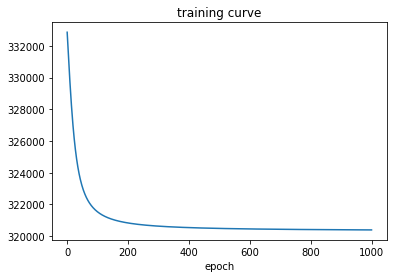

In [40]:
plt.plot(costtr_history)
plt.title ("training curve")
plt.xlabel("epoch")
training_RMS_error = np.sqrt(costtr_history[999]/576)
testing_RMS_error = np.sqrt(costte_history[999]/192)
print('training_RMS_error = {:.4f}'.format(training_RMS_error))
print('testing_RMS_error = {:.4f}'.format(testing_RMS_error))

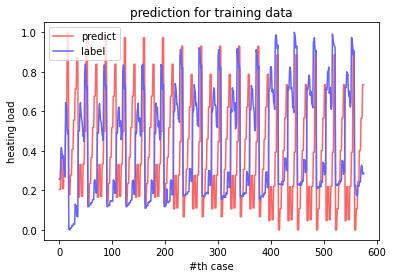

In [41]:
range1 = np.max(np.squeeze(y_train)) - np.min(np.squeeze(y_train))
aa=(np.squeeze(y_train) - np.min(np.squeeze(y_train))) / range1
range2 = np.max(np.squeeze(gotrain["X7"])) - np.min(np.squeeze(gotrain["X7"]))
ab=(np.squeeze(gotrain["X7"]) - np.min(np.squeeze(gotrain["X7"]))) / range2
plt.plot (ab,color=(255/255,100/255,100/255),label="predict")
plt.plot (aa,color=(100/255,100/255,255/255),label="label")
plt.title ("prediction for training data")
# title
plt.ylabel ("heating load")
# y label
plt.xlabel("#th case") #x label
plt.legend()
plt. show( )

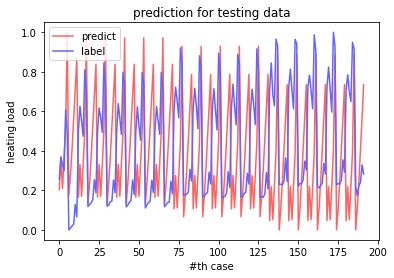

In [42]:
range1 = np.max(np.squeeze(y_test)) - np.min(np.squeeze(y_test))
aa=(np.squeeze(y_test) - np.min(np.squeeze(y_test))) / range1
range2 = np.max(np.squeeze(gotest["X7"])) - np.min(np.squeeze(gotest["X7"]))
ab=(np.squeeze(gotest["X7"]) - np.min(np.squeeze(gotest["X7"]))) / range2
plt.plot (ab,color=(255/255,100/255,100/255),label="predict")
plt.plot (aa,color=(100/255,100/255,255/255),label="label")
plt.title ("prediction for testing data")
plt.ylabel ("heating load")
plt.xlabel("#th case") 
plt.legend()
plt. show( )

2

In [27]:
def errortr(gotrain,y_train):
    a=np.squeeze(gotrain['X7'])
    b=np.squeeze(y_train)
    n=0
    for i in range(281):
        if a[i]>0.5:
            a[i]=1
        else:
            a[i]=0
    for i in range(281):
        if a[i]==b[i]:
            n+=1
    return 1-n/281
def errorte(gotest,y_test):
    a=np.squeeze(gotest['X7'])
    b=np.squeeze(y_test)
    n=0
    for i in range(70):
        if a[i]>0.5:
            a[i]=1
        else:
            a[i]=0
    for i in range(70):
        if a[i]==b[i]:
            n+=1
    return 1-n/70

In [13]:
df2 = pd.read_csv("ionosphere_data.csv",header=None)
for i in range(351):
    if df2.loc[i,34]=='g':
        df2.loc[i,34] = 1
    else:
        df2.loc[i,34] = 0
df2[34].astype(float)
y = df2[34]
df2.drop([34], axis=1, inplace=True)
y_train = y.iloc[:281]
y_train = y_train.to_numpy()
y_train = y_train.reshape((281,1))
y_test = y.iloc[281:351]
y_test = y_test.to_numpy()
y_test = y_test.reshape((70,1))
X_train = df2.iloc[:281,:]
X_test = df2.iloc[281:351,:]
X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

In [28]:
costtr_history = []
costte_history = []
trainerror_history = []
testerror_history = []
lr = 0.001
epoch = 150
allW_values,allb_values = initial(network3)
for i in range(epoch):
    gotrain = forward(X_train,network3,allW_values,allb_values)
    gotest = forward(X_test,network3,allW_values,allb_values)

    
    losstrain = loss2(y_train,gotrain["X7"])
    losstest = loss2(y_test,gotest["X7"])
    print('(epoch = {:4d}, loss = {:.4f})'.format(i + 1, losstrain))
    
    costtr_history.append(losstrain)
    costte_history.append(losstest)
    dW,db = backward(y_train,gotrain["X7"],network3,allW_values,allb_values,gotrain)
    allW_values,allb_values = update(network3,allW_values,allb_values,dW,db,lr)
    trainerror = errortr(gotrain,y_train)
    testerror = errorte(gotest,y_test)
    trainerror_history.append(trainerror)
    testerror_history.append(testerror)

(epoch =    1, loss = 357.3883)
(epoch =    2, loss = 350.2541)
(epoch =    3, loss = 343.8987)
(epoch =    4, loss = 338.1629)
(epoch =    5, loss = 332.9321)
(epoch =    6, loss = 328.1297)
(epoch =    7, loss = 323.6867)
(epoch =    8, loss = 319.5306)
(epoch =    9, loss = 315.6617)
(epoch =   10, loss = 312.0439)
(epoch =   11, loss = 308.6421)
(epoch =   12, loss = 305.4434)
(epoch =   13, loss = 302.4244)
(epoch =   14, loss = 299.5628)
(epoch =   15, loss = 296.8442)
(epoch =   16, loss = 294.2534)
(epoch =   17, loss = 291.7823)
(epoch =   18, loss = 289.4192)
(epoch =   19, loss = 287.1561)
(epoch =   20, loss = 284.9883)
(epoch =   21, loss = 282.9119)
(epoch =   22, loss = 280.9181)
(epoch =   23, loss = 278.9995)
(epoch =   24, loss = 277.1529)
(epoch =   25, loss = 275.3726)
(epoch =   26, loss = 273.6586)
(epoch =   27, loss = 272.0037)
(epoch =   28, loss = 270.4055)
(epoch =   29, loss = 268.8624)
(epoch =   30, loss = 267.3706)
(epoch =   31, loss = 265.9258)
(epoch =

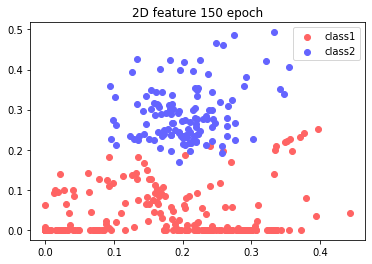

In [12]:
draw = pd.read_csv("ionosphere_data.csv",header=None)
for i in range(351):
    if draw.loc[i,34]=='g':
        draw.loc[i,34] = 1
    else:
        draw.loc[i,34] = 0
draw[34].astype(float)
draw = draw.sort_values(by=[34],ascending=False)
n=draw[34].sum()
draw.drop([34], axis=1, inplace=True)
class1 = draw.iloc[:n,:]
class1 = class1.T
class2 = draw.iloc[n:351,:]
class2 = class2.T
go={'X0':class1}
for idx,layer in enumerate(network3):
    A = np.dot(allW_values['W' + str(idx+1)],go['X' + str(idx)]) + allb_values['b' + str(idx+1)]
    if layer["activation"] == "sigmoid":
      X = 1/(1+np.exp(-A))
    elif layer["activation"] == "relu":
      X = np.maximum(0,A)
    go['A' + str(idx+1)] = A
    go['X' + str(idx+1)] = X
a=go['X4']
go={'X0':class2}
for idx,layer in enumerate(network3):
    A = np.dot(allW_values['W' + str(idx+1)],go['X' + str(idx)]) + allb_values['b' + str(idx+1)]
    if layer["activation"] == "sigmoid":
      X = 1/(1+np.exp(-A))
    elif layer["activation"] == "relu":
      X = np.maximum(0,A)
    go['A' + str(idx+1)] = A
    go['X' + str(idx+1)] = X
b=go['X6']
plt.scatter (a[3],a[19],color=(255/255,100/255,100/255),label="class1")
plt.scatter (b[3],b[19],color=(100/255,100/255,255/255),label="class2")
plt.title ("2D feature 150 epoch")
plt.legend()
plt.show( )

In [29]:
lr = 0.001
epoch = 1000
for i in range(epoch):
    gotrain = forward(X_train,network3,allW_values,allb_values)
    gotest = forward(X_test,network3,allW_values,allb_values)
    losstrain = loss2(y_train,gotrain["X7"])
  
  
    losstest = loss2(y_test,gotest["X7"])
    print('(epoch = {:4d}, loss = {:.4f})'.format(i + 151, losstrain))
    costtr_history.append(losstrain)
    costte_history.append(losstest)
    dW,db = backward(y_train,gotrain["X7"],network3,allW_values,allb_values,gotrain)
    allW_values,allb_values = update(network3,allW_values,allb_values,dW,db,lr)
    trainerror = errortr(gotrain,y_train)
    testerror = errorte(gotest,y_test)
    trainerror_history.append(trainerror)
    testerror_history.append(testerror)

(epoch =  151, loss = 204.1214)
(epoch =  152, loss = 203.9321)
(epoch =  153, loss = 203.7449)
(epoch =  154, loss = 203.5599)
(epoch =  155, loss = 203.3767)
(epoch =  156, loss = 203.1951)
(epoch =  157, loss = 203.0154)
(epoch =  158, loss = 202.8375)
(epoch =  159, loss = 202.6614)
(epoch =  160, loss = 202.4871)
(epoch =  161, loss = 202.3147)
(epoch =  162, loss = 202.1440)
(epoch =  163, loss = 201.9753)
(epoch =  164, loss = 201.8083)
(epoch =  165, loss = 201.6428)
(epoch =  166, loss = 201.4789)
(epoch =  167, loss = 201.3169)
(epoch =  168, loss = 201.1566)
(epoch =  169, loss = 200.9983)
(epoch =  170, loss = 200.8416)
(epoch =  171, loss = 200.6866)
(epoch =  172, loss = 200.5331)
(epoch =  173, loss = 200.3813)
(epoch =  174, loss = 200.2312)
(epoch =  175, loss = 200.0824)
(epoch =  176, loss = 199.9351)
(epoch =  177, loss = 199.7891)
(epoch =  178, loss = 199.6447)
(epoch =  179, loss = 199.5017)
(epoch =  180, loss = 199.3599)
(epoch =  181, loss = 199.2196)
(epoch =

(epoch =  408, loss = 184.0539)
(epoch =  409, loss = 184.0189)
(epoch =  410, loss = 183.9840)
(epoch =  411, loss = 183.9492)
(epoch =  412, loss = 183.9144)
(epoch =  413, loss = 183.8798)
(epoch =  414, loss = 183.8453)
(epoch =  415, loss = 183.8109)
(epoch =  416, loss = 183.7766)
(epoch =  417, loss = 183.7424)
(epoch =  418, loss = 183.7083)
(epoch =  419, loss = 183.6743)
(epoch =  420, loss = 183.6404)
(epoch =  421, loss = 183.6065)
(epoch =  422, loss = 183.5728)
(epoch =  423, loss = 183.5392)
(epoch =  424, loss = 183.5057)
(epoch =  425, loss = 183.4723)
(epoch =  426, loss = 183.4390)
(epoch =  427, loss = 183.4057)
(epoch =  428, loss = 183.3725)
(epoch =  429, loss = 183.3395)
(epoch =  430, loss = 183.3065)
(epoch =  431, loss = 183.2736)
(epoch =  432, loss = 183.2407)
(epoch =  433, loss = 183.2079)
(epoch =  434, loss = 183.1751)
(epoch =  435, loss = 183.1425)
(epoch =  436, loss = 183.1100)
(epoch =  437, loss = 183.0775)
(epoch =  438, loss = 183.0451)
(epoch =

(epoch =  665, loss = 176.4924)
(epoch =  666, loss = 176.4647)
(epoch =  667, loss = 176.4371)
(epoch =  668, loss = 176.4094)
(epoch =  669, loss = 176.3817)
(epoch =  670, loss = 176.3540)
(epoch =  671, loss = 176.3264)
(epoch =  672, loss = 176.2987)
(epoch =  673, loss = 176.2710)
(epoch =  674, loss = 176.2434)
(epoch =  675, loss = 176.2157)
(epoch =  676, loss = 176.1880)
(epoch =  677, loss = 176.1603)
(epoch =  678, loss = 176.1327)
(epoch =  679, loss = 176.1050)
(epoch =  680, loss = 176.0773)
(epoch =  681, loss = 176.0496)
(epoch =  682, loss = 176.0219)
(epoch =  683, loss = 175.9942)
(epoch =  684, loss = 175.9664)
(epoch =  685, loss = 175.9387)
(epoch =  686, loss = 175.9111)
(epoch =  687, loss = 175.8834)
(epoch =  688, loss = 175.8557)
(epoch =  689, loss = 175.8280)
(epoch =  690, loss = 175.8002)
(epoch =  691, loss = 175.7725)
(epoch =  692, loss = 175.7447)
(epoch =  693, loss = 175.7168)
(epoch =  694, loss = 175.6889)
(epoch =  695, loss = 175.6610)
(epoch =

(epoch =  922, loss = 169.2473)
(epoch =  923, loss = 169.2178)
(epoch =  924, loss = 169.1882)
(epoch =  925, loss = 169.1587)
(epoch =  926, loss = 169.1292)
(epoch =  927, loss = 169.0996)
(epoch =  928, loss = 169.0700)
(epoch =  929, loss = 169.0404)
(epoch =  930, loss = 169.0107)
(epoch =  931, loss = 168.9811)
(epoch =  932, loss = 168.9515)
(epoch =  933, loss = 168.9219)
(epoch =  934, loss = 168.8923)
(epoch =  935, loss = 168.8626)
(epoch =  936, loss = 168.8330)
(epoch =  937, loss = 168.8033)
(epoch =  938, loss = 168.7737)
(epoch =  939, loss = 168.7440)
(epoch =  940, loss = 168.7142)
(epoch =  941, loss = 168.6845)
(epoch =  942, loss = 168.6546)
(epoch =  943, loss = 168.6248)
(epoch =  944, loss = 168.5949)
(epoch =  945, loss = 168.5650)
(epoch =  946, loss = 168.5351)
(epoch =  947, loss = 168.5052)
(epoch =  948, loss = 168.4753)
(epoch =  949, loss = 168.4454)
(epoch =  950, loss = 168.4155)
(epoch =  951, loss = 168.3856)
(epoch =  952, loss = 168.3557)
(epoch =

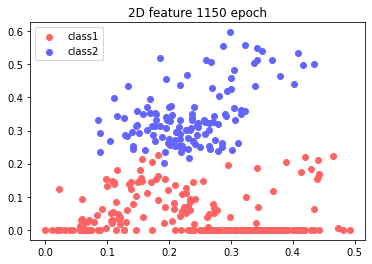

In [95]:
go={'X0':class1}
for idx,layer in enumerate(network3):
    A = np.dot(allW_values['W' + str(idx+1)],go['X' + str(idx)]) + allb_values['b' + str(idx+1)]
    if layer["activation"] == "sigmoid":
      X = 1/(1+np.exp(-A))
    elif layer["activation"] == "relu":
      X = np.maximum(0,A)
    go['A' + str(idx+1)] = A
    go['X' + str(idx+1)] = X
a=go['X4']
go={'X0':class2}
for idx,layer in enumerate(network3):
    A = np.dot(allW_values['W' + str(idx+1)],go['X' + str(idx)]) + allb_values['b' + str(idx+1)]
    if layer["activation"] == "sigmoid":
      X = 1/(1+np.exp(-A))
    elif layer["activation"] == "relu":
      X = np.maximum(0,A)
    go['A' + str(idx+1)] = A
    go['X' + str(idx+1)] = X
b=go['X6']
plt.scatter (a[3],a[19],color=(255/255,100/255,100/255),label="class1")
plt.scatter (b[3],b[19],color=(100/255,100/255,255/255),label="class2")
plt.title ("2D feature 1150 epoch")
plt.legend()
plt.show( )

Text(0.5, 0, 'epoch')

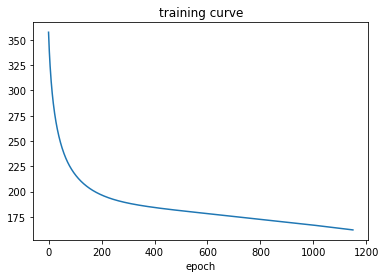

In [120]:
plt.plot(costtr_history)
plt.title ("training curve")
plt.xlabel("epoch")

training error rare = 0.2206


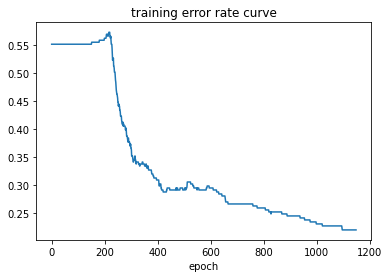

In [35]:
plt.plot(trainerror_history)
plt.title ("training error rate curve")
plt.xlabel("epoch")
print('training error rare = {:.4f}'.format(trainerror_history[-1]))

test error rare = 0.3429


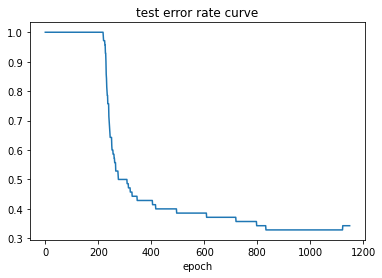

In [36]:
plt.plot(testerror_history)
plt.title ("test error rate curve")
plt.xlabel("epoch")
print('test error rare = {:.4f}'.format(testerror_history[-1]))